## MODEL 
* Install muna ako NVIDIA CUDA tas cuDNN para di sumabog PC 

In [6]:
import os
import time
import numpy as np
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

In [7]:
def extract_colors(image, k=6):
    if len(image.shape) == 2 or image.shape[-1] == 1:  
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    pixels = lab_image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_.flatten()
    return dominant_colors


In [ ]:
def load_images_and_labels(folder, label, k=6):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(image_path, color_mode="rgb"))
        image = image.astype(np.uint8)
        color_features = extract_colors(image, k=k)
        images.append(color_features.reshape(1, -1))

    labels = [label] * len(images)
    return np.vstack(images), np.array(labels)

In [10]:
train_jaundiced_images, train_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class1/train", 1)
train_healthy_images, train_healthy_labels = load_images_and_labels("./new/Normal Class1/train", 0)

X_train = np.vstack((train_jaundiced_images, train_healthy_images))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))
X_train, y_train = shuffle(X_train, y_train, random_state=1)

test_jaundiced_images, test_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class1/test", 1)
test_healthy_images, test_healthy_labels = load_images_and_labels("./new/Normal Class1/test", 0)

X_test = np.vstack((test_jaundiced_images, test_healthy_images))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))

val_jaundiced_images, val_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class1/validate", 1)
val_healthy_images, val_healthy_labels = load_images_and_labels("./new/Normal Class1/validate", 0)

X_val = np.vstack((val_jaundiced_images, val_healthy_images))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))

print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Jaundiced images shape:", train_jaundiced_images.shape)
print("Healthy images shape:", train_healthy_images.shape)
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("First 5 rows of X_train:", X_train[:5])

Test data shape: (19, 18)
Validation data shape: (42, 18)
Jaundiced images shape: (65, 18)
Healthy images shape: (76, 18)
X_train shape: (141, 18)
X_train dtype: float64
First 5 rows of X_train: [[230.03559137 135.35003777 136.06698565 100.77506911 140.67202815
  132.63282232 176.14144211 141.86484184 138.11449569 140.9911669
  140.71424144 134.13947001  45.67358916 137.66591422 129.73227991
  202.96785882 140.60504596 139.50432799]
 [209.50644234 132.51498975 134.90431025 102.18666178 135.38197142
  138.22484427 165.17258926 136.25404769 137.22469406 134.98060136
  137.18474654 138.40691204 189.56931627 134.2757141  136.2895179
   59.54564896 133.34068103 134.22553051]
 [174.90862432 142.49375739 140.37034688  94.66681373 139.74508074
  134.92817436 198.4378545  137.92172547 138.57852177 151.90337899
  144.19592325 139.90476806  59.13982372 136.49479167 133.40117521
  127.60388077 145.88185358 138.41207634]
 [ 76.57366467 151.83096258 163.58480434 220.60305549 126.96176154
  176.69050

In [11]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (141, 18)
X_test shape: (19, 18)
X_val shape: (42, 18)


In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit 
X_test = scaler.transform(X_test)       # Transform test data (images only with no annotations but with features)
X_val = scaler.transform(X_val)

In [13]:
model = Sequential([
    Dense(512, kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\kenji\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\kenji\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [24]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
best_model_checkpoint = ModelCheckpoint('./checkpoints./bestKMeansHSV.keras', monitor='val_loss', mode='min', save_best_only=True)

# Training
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler, best_model_checkpoint]
)

elapsed_time = time.time() - start_time

# Evaluate Model
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
stopped_epoch = early_stopping.stopped_epoch

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}")
print(f"Training stopped at Epoch: {stopped_epoch}, Time Taken: {elapsed_time:.2f} sec")


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 0.6460 - precision_10: 1.0000 - recall_10: 1.0000 - val_accuracy: 0.8333 - val_loss: 1.2004 - val_precision_10: 0.8000 - val_recall_10: 0.8421 - learning_rate: 5.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9814 - loss: 0.6479 - precision_10: 0.9882 - recall_10: 0.9726 - val_accuracy: 0.8333 - val_loss: 1.1209 - val_precision_10: 0.8750 - val_recall_10: 0.7368 - learning_rate: 5.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9946 - loss: 0.6082 - precision_10: 0.9882 - recall_10: 1.0000 - val_accuracy: 0.7857 - val_loss: 1.0869 - val_precision_10: 0.8125 - val_recall_10: 0.6842 - learning_rate: 5.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9647 - loss: 0.6600 - precision_10: 0.9364 - recall_10: 0.9869 - val_accuracy: 0.8095 - val_loss: 1.2169 - val_precision_10: 0.7895 - val_recall_10: 0.7895 - learning_rate: 5.0000e-04
Epoch 5/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



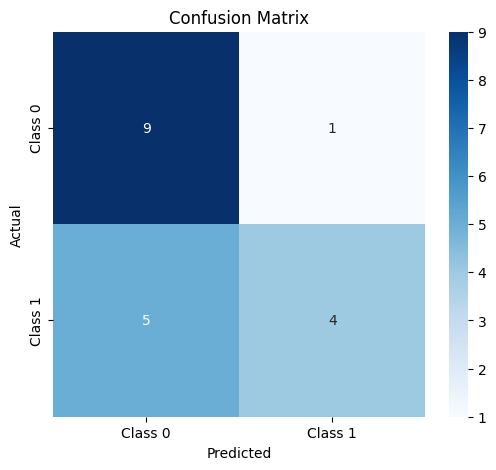

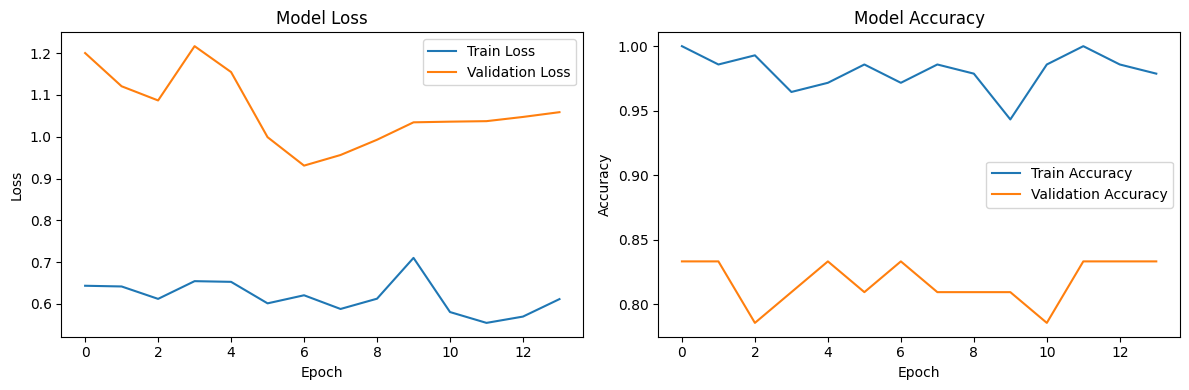

In [25]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Loss and Accuracy Plots
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("Jaundice_Classifier_kmeans1.keras") 